In [1]:
# Importación de paquetes.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
# Función para aplicar suavizado utilizando el filtro Savitzky-Golay en una región específica
def apply_savgol_smoothing(x, y, transition_index, window_length1, polyorder1, window_length2, polyorder2):
    y_smooth = np.copy(y)
    y_smooth[:transition_index+1] = ss.savgol_filter(y[:transition_index+1], window_length=window_length1, polyorder=polyorder1)
    y_smooth[transition_index:] = ss.savgol_filter(y[transition_index:], window_length=window_length2, polyorder=polyorder2)
    return y_smooth

In [3]:
# Importación de datos TG de Laponita pura.
df1 = pd.read_csv('./nuevaCarpeta/Laponita_TG.txt',sep='\t',header=None,names=['Temperatura','H2O','TG'], 
        usecols=['Temperatura','H2O','TG'],decimal=',')

In [4]:
pd.options.display.float_format = "{:,.5f}".format
df1 = df1.astype(float)
df1["Temperatura"][:]

0         19.71000
1         19.71000
2         19.54000
3         19.45000
4         19.47000
           ...    
4703   1,001.20000
4704   1,001.40000
4705   1,001.60000
4706   1,001.80000
4707   1,002.10000
Name: Temperatura, Length: 4708, dtype: float64

In [5]:
x = df1["Temperatura"].values
y = df1["TG"].values

In [6]:
# Filtrado de datos.
df1.loc[df1["TG"]<=0]

,Temperatura,H2O,TG
1,19.71000,0.00000,-0.00217
407,29.21000,0.00000,-0.00034
408,29.38000,0.00000,-0.00338
409,29.53000,0.00000,-0.00661
410,29.70000,0.00000,-0.01042
...,...,...,...
4703,"1,001.20000",0.00000,-16.52500
4704,"1,001.40000",0.00000,-16.52200
4705,"1,001.60000",0.00000,-16.51900
4706,"1,001.80000",0.00000,-16.51800


In [7]:
x = x[407:]
y = y[407:]

In [8]:
# Interpolación de los puntos del eje x.
x_interpolated = np.linspace(x.min(), x.max(), len(x))
y_interpolated = interp1d(x, y)(x_interpolated)

In [9]:
def calculate_derivative(x, y):
    dx = np.gradient(x)  # Calcular el espaciado entre puntos en el eje x
    dy = np.gradient(y)  # Calcular la diferencia entre puntos en el eje y
    derivative = dy / dx  # Calcular la derivada punto por punto
    return derivative
#(x_interpolated, y_smooth)
derivative = calculate_derivative(x, y)
print(derivative)

[-0.01785559 -0.01958047 -0.02198344 ...  0.01        0.004
  0.00333333]


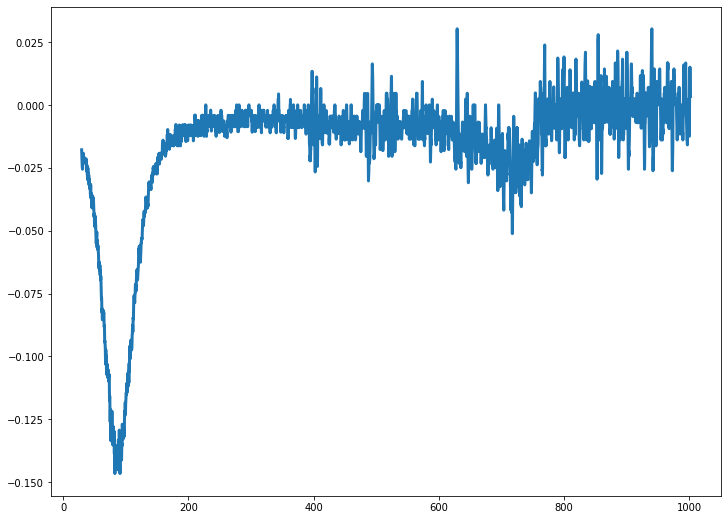

In [10]:
plt.figure(figsize=(12, 9))
plt.plot(x_interpolated[:], derivative[:], linewidth=3, label="y_dev_smooth")

In [11]:
end_start = np.where(x_interpolated > 150)[0][0]  # Filtrado de datos
print(end_start)

534


In [12]:
# Definir las regiones donde se aplicará el suavizado
transition_index = end_start

# Aplicar suavizado en cada región con diferentes parámetros
y_smooth = apply_savgol_smoothing(x_interpolated, y_interpolated, transition_index, window_length1=20, polyorder1=2, window_length2=100, polyorder2=2)

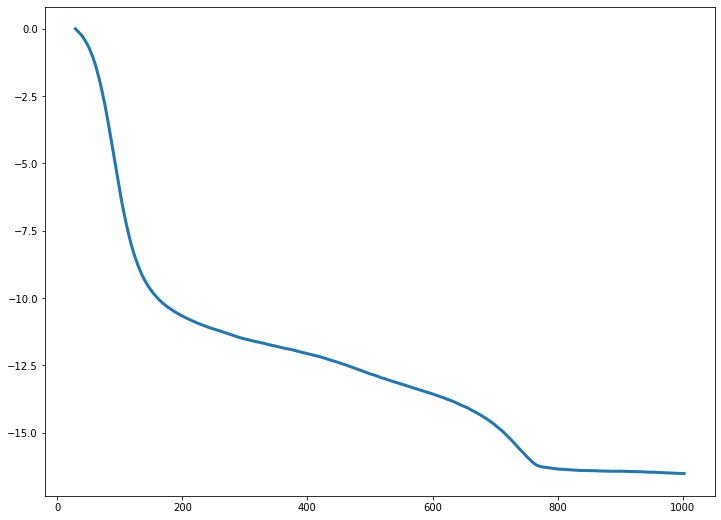

In [13]:
plt.figure(figsize=(12, 9))
plt.plot(x_interpolated, y_smooth, linewidth=3, label="y_smoothed")

In [14]:
derivative = calculate_derivative(x_interpolated, y_smooth)
print(derivative)

[-0.02324097 -0.02316649 -0.02301753 ...  0.00102347  0.00106845
  0.00109094]


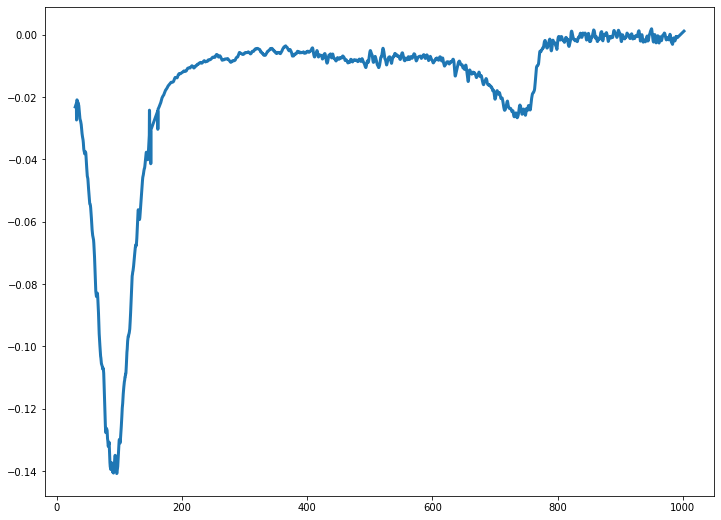

In [15]:
plt.figure(figsize=(12, 9))
plt.plot(x_interpolated, derivative, linewidth=3, label="y_dev_smooth")

2


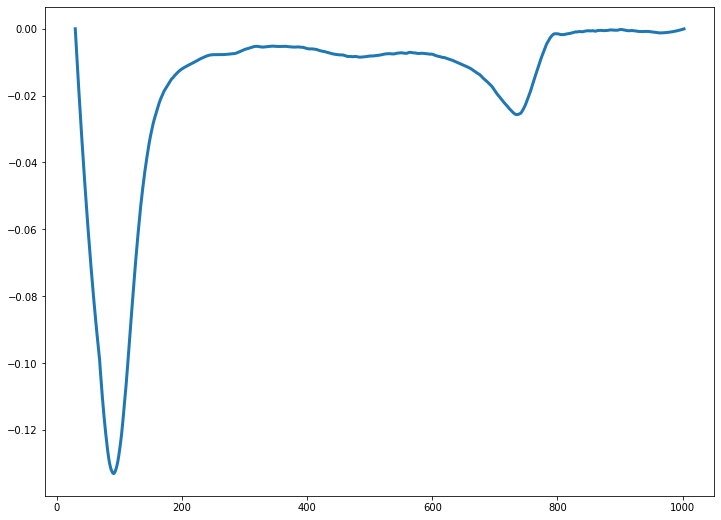

In [16]:
# Aplicación del filtro de suavizado con kernel gaussiano en la primera derivada.
y_dev_smooth = ss.savgol_filter(derivative,window_length=350,polyorder=2,deriv=0)
a = np.where(y_dev_smooth < 0)[0][0]  # Filtrado de datos
print(a)
plt.figure(figsize=(12, 9))
plt.plot(x_interpolated[a:], y_dev_smooth[a:], linewidth=3, label="y_dev_smooth")

In [32]:
print(x_interpolated[a])
print(y_dev_smooth[a])

29.662506976744186
-1.3516210813204225e-05


In [18]:
# Exportación de datos DTG de Laponita pura.
df2 = pd.DataFrame({"Temperatura":x_interpolated,"TG_smooth":y_smooth,"TG_dev":y_dev_smooth})
df2.to_csv('./nuevaCarpeta/Laponita_TG_smooth.txt',sep='\t',index=False,decimal=',')

In [27]:
b = np.where(x_interpolated>157.9)[0][0] #filtrado de datos
b

569

In [28]:
print(x_interpolated[b])
print(y_dev_smooth[b])

157.94823488372094
-0.025774456524857763


In [33]:
min_temp_1 = np.where(y_dev_smooth == min(y_dev_smooth[a:b]))
print(x_interpolated[min_temp_1])
print(y_dev_smooth[min_temp_1])

[90.97720233]
[-0.13307534]


In [29]:
# Integración numérica con la regla trapezoidal.
resultado_original = np.trapz(y_dev_smooth[a:b],x_interpolated[a:b])
resultado_original

-10.013552391276402

In [44]:
# Cálculo del error
a_e = np.where(x>(x_interpolated[a]-0.1))[0][0]
b_e = np.where(x>(x_interpolated[b]+0.5))[0][0]
resultado_desplazado = np.trapz(y_dev_smooth[a_e:b_e], x_interpolated[a_e:b_e])
print("resultado desplazado:",resultado_desplazado)
error_integral = np.abs(resultado_original - resultado_desplazado)
print("error_integral:",error_integral)

resultado desplazado: -9.654497366549872
error_integral: 0.35905502472652984


In [36]:
c = np.where(x_interpolated>640.4)[0][0] #filtrado de datos
c

2702

In [37]:
d = np.where(x_interpolated>789.5)[0][0] #filtrado de datos
d

3361

In [38]:
min_temp_2 = np.where(y_dev_smooth == min(y_dev_smooth[c:d]))
print(x_interpolated[min_temp_2])
print(y_dev_smooth[min_temp_2])

[735.34713721]
[-0.02568378]


In [41]:
# Integración numérica con la regla trapezoidal.
resultado_original_hidrox = np.trapz(y_dev_smooth[c:d],x_interpolated[c:d])
resultado_original_hidrox

-2.413753696820382

In [42]:
# Cálculo del error
c_e = np.where(x>(x_interpolated[c]-0.5))[0][0]
d_e = np.where(x>(x_interpolated[d]+0.5))[0][0]
resultado_desplazado_hidrox = np.trapz(y_dev_smooth[c_e:d_e], x_interpolated[c_e:d_e])
print("resultado desplazado:",resultado_desplazado_hidrox)
error_integral_hidrox = np.abs(resultado_original_hidrox - resultado_desplazado_hidrox)
print("error_integral:",error_integral_hidrox)

resultado desplazado: -2.54333382218509
error_integral: 0.12958012536470775
